# Dataset Fast Food Classification

On récupère ce dataset depuis kaggle. 

In [19]:
!pip install tensorflow matplotlib numpy kaggle keras_preprocessing scikit-learn
!pip install -q kaggle
# !pip install tensorflow-metal

On commence par créer notre dataset d'entrainement (10 500 images, 70%) et notre dataset de test (4 500 images, 30%)
Le dataset contient 10 classes correspondantes à 10 plats de fast-food différents (burger, frites, donut, ...)

In [20]:
import os

try:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

except:
    print("Skipping google colab part")

import kaggle.api

if not os.path.exists('./fastfooddataset'):
    kaggle.api.authenticate() 
    kaggle.api.dataset_download_files('utkarshsaxenadn/fast-food-classification-dataset', path='./fastfooddataset', unzip=True)
else:
    print("dataset already downloaded")

Skipping google colab part
dataset already downloaded


In [21]:
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set the path to your dataset
dataset_path = './fastfooddataset/Fast Food Classification V2/Train'

# Define the image size and batch size
image_size = (200, 200)
batch_size = 50

train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    validation_split=0.2,
    label_mode='categorical',
    subset="both",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True)

normalization_layer = tf.keras.layers.Rescaling(1./255)

class_names = train_dataset.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 10 classes.
Using 12000 files for training.
Using 3000 files for validation.
['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


Affichage de quelques images du dataset

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10, 10))
try:
    for images, labels in train_dataset.take(1):
      for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
except:
    pass

2023-12-06 23:14:54.103453: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 1000x1000 with 0 Axes>

Création d'un modèle. 
On prend pour commencer une architecture de CNN classique, en général adaptée à la classification d'images.

In [24]:
import os 
import numpy as np

model_path = './models/model1'

model = None

if os.path.exists(model_path):
    try:
        model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully.")
        history = np.load('./history/history1.npy',allow_pickle='TRUE').item()
        
        # Now, you can use the loaded_model for predictions or further training
    except Exception as e:
        print(f"Error loading the model: {e}")

if model is None:
    model = tf.keras.models.Sequential(
        [        
            tf.keras.layers.Rescaling(1./255, input_shape=(200, 200, 3)),
            tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ]
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer='adam',
        metrics=["accuracy"],
    )
    
    model.build()
    print(model.summary())
    history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
    model.save("/Users/timothee-l/Documents/CPE/5ETI/cpeMachineLearning/Projet/models/model1")
    np.save('./history/history1.npy',history.history)
    history = history.history


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 99, 99, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)       

INFO:tensorflow:Assets written to: /Users/timothee-l/Documents/CPE/5ETI/cpeMachineLearning/Projet/models/model1/assets


Visualisation de l'entrainement

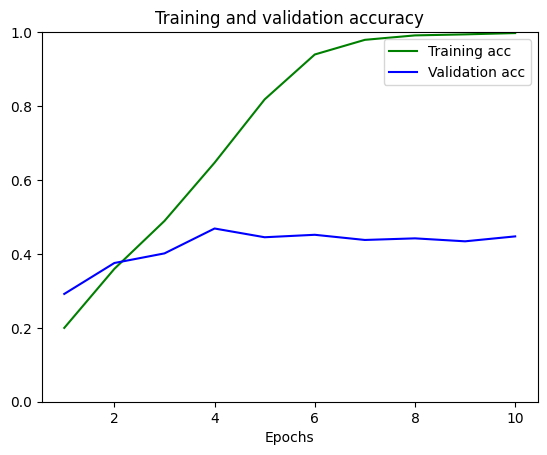

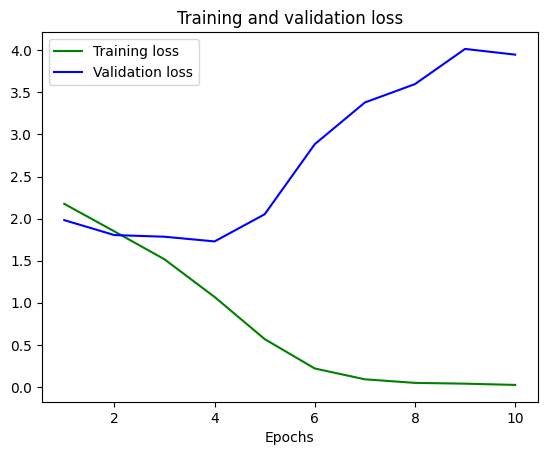

In [25]:
import matplotlib.pyplot as plt

def plot_history(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
        
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim(0, 1)
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.show()
    
plot_history(history)

# Modèle 2
On fait évoluer notre modèle
- On va ajouter des dropout pour tenter de compenser l'overfit

In [26]:
import os 
import tensorflow as tf

model2_path = './models/model2'

model2 = None

if os.path.exists(model2_path):
    try:
        model2 = tf.keras.models.load_model(model_path)
        history2 = np.load('./history/history2.npy',allow_pickle='TRUE').item()
        print("Model loaded successfully.")
        
        # Now, you can use the loaded_model for predictions or further training
    except Exception as e:
        print(f"Error loading the model: {e}")

if model2 is None:
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
    model2 = tf.keras.models.Sequential(
        [        
            tf.keras.layers.Rescaling(1./255, input_shape=(200, 200, 3)),
            data_augmentation,
            tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ]
    )
    
    model2.compile(
        loss="categorical_crossentropy",
        optimizer='adam',
        metrics=["accuracy"],
    )
    
    model2.build()
    print(model2.summary())
    history2 = model2.fit(train_dataset, epochs=20, validation_data=validation_dataset)
    model2.save("./models/model2")
    np.save('./history/history2.npy',history2.history)
    history2 = history2.history


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 99, 99, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 99, 99, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 32)        4640      
                                                      

INFO:tensorflow:Assets written to: ./models/model2/assets


Viusalisation de l'entrainement

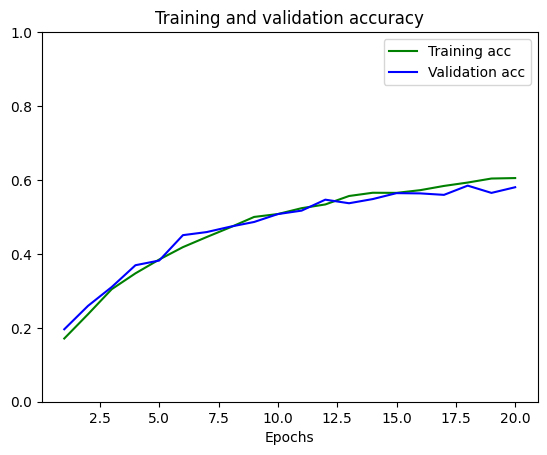

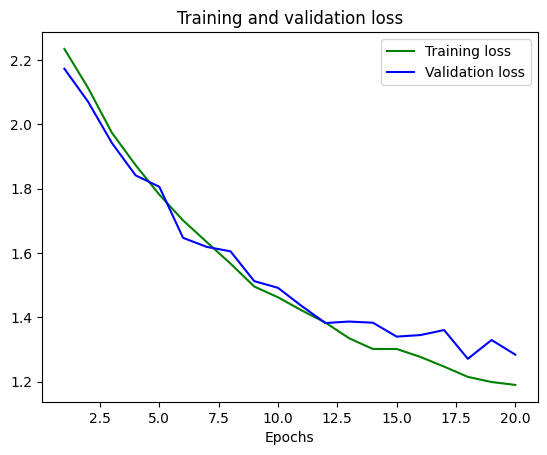

In [27]:
plot_history(history2)

# Comparaison des deux models

In [32]:
import tensorflow as tf

data_dir = './fastfooddataset/Fast Food Classification V2/Valid'
batch_size = 32

data_generator = ImageDataGenerator(rescale=1./255)

prediction_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True)

Found 3500 files belonging to 10 classes.


In [33]:
evaluation_model1 = model.evaluate(prediction_data)
evaluation_model2 = model2.evaluate(prediction_data)

110/110 [==============================] - 14s 129ms/step - loss: 1.3403 - accuracy: 0.5706


## Predictions

In [35]:
from sklearn.metrics import f1_score

predictions_model1 = model.predict(prediction_data)
predictions_model2 = model.predict(prediction_data)

  Using cached scikit_learn-1.3.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.11.4-cp310-cp310-macosx_12_0_arm64.whl.metadata (112 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached scikit_learn-1.3.2-cp310-cp310-macosx_12_0_arm64.whl (9.5 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scipy-1.11.4-cp310-cp310-macosx_12_0_arm64.whl (29.8 MB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
110/110 [==============================] - 14s 125ms/step


f1-score